# Bitacora #3 - Entrenamiento con parametros ajustados
**Fecha:** 2026-02-16  
**Autor:** Francis Bravo  

## 1. Motivacion

En el [entrenamiento #1](bitacora_2_entrenamiento_2026-02-15.ipynb#train-1) de la bitacora anterior se identificaron los siguientes problemas tras 3500 epocas con parametros por defecto:

- **Win Rate estancado** en rendimiento aleatorio (~0.5 vs random, ~0.37 vs bot_loss-BT)
- **Q_select colapsado** a -1.0 sin importar la recompensa (cabeza muerta)
- **Q_place sin diferenciacion** entre victorias y derrotas
- **Loss estancado** en ~0.25 con tendencia al alza (minimo local)
- **Tableros vacios** por N_LAST_STATES=2 (solo captura primeros movimientos)

Se proponen cambios en 7 hiperparametros para atacar estos problemas.

## 2. Cambios de parametros

### 2.1 Resumen de cambios

| Parametro | Anterior | Nuevo | Razon |
|-----------|----------|-------|-------|
| N_LAST_STATES (INIT/FINAL) | 2/2 | 6/6 | Mas diversidad de estados |
| LR | 5e-5 | 5e-4 | Escapar del minimo local |
| LR_F | 5e-5 | 1e-5 | Activar cosine annealing |
| GAMMA | 0.99 | 0.90 | Senal mas directa para juego corto |
| BATCH_SIZE | 30 | 64 | Reducir varianza de gradientes |
| TEMPERATURE_EXPLORE | 2 | 1.0 | Self-play de mejor calidad |
| TAU | 0.01 | 0.005 | Target network mas estable |

### 2.2 Parametros completos del entrenamiento

Parametros configurados en ambos scripts. Los valores **en negrita** son los que cambiaron respecto a la bitacora #2.

#### Configuracion principal

| Parametro | Valor | trainRL | resume | Descripcion |
|-----------|-------|---------|--------|-------------|
| STARTING_NET | `None` | [L42](trainRL.py#L42) | [L45](trainRL_resume_latest.py#L45) | Pesos aleatorios (sin checkpoint previo) |
| EXPERIMENT_NAME | `"05_LOSS"` | [L43](trainRL.py#L43) | [L46](trainRL_resume_latest.py#L46) | Nombre del experimento |
| ARCHITECTURE | `QuartoCNN_uncoupled` | [L50](trainRL.py#L50) | [L54](trainRL_resume_latest.py#L54) | Red con cabezas independientes |
| LOSS_APPROACH | `"combined_avg"` | [L51](trainRL.py#L51) | [L55](trainRL_resume_latest.py#L55) | Promedio de Q-values de place y select |
| REWARD_FUNCTION | `"propagate"` | [L52](trainRL.py#L52) | [L56](trainRL_resume_latest.py#L56) | Recompensa final propagada a todos los estados |

#### Hiperparametros de entrenamiento

| Parametro | Valor | trainRL | resume | Descripcion |
|-----------|-------|---------|--------|-------------|
| EPOCHS | `3000` | [L66](trainRL.py#L66) | [L70](trainRL_resume_latest.py#L70) | Epocas totales |
| **BATCH_SIZE** | **`64`** | [L61](trainRL.py#L61) | [L65](trainRL_resume_latest.py#L65) | Muestras por batch |
| **LR** | **`5e-4`** | [L111](trainRL.py#L111) | [L117](trainRL_resume_latest.py#L117) | Learning rate inicial (10x mayor) |
| **LR_F** | **`1e-5`** | [L112](trainRL.py#L112) | [L118](trainRL_resume_latest.py#L118) | Learning rate final (activa cosine annealing) |
| **TAU** | **`0.005`** | [L113](trainRL.py#L113) | [L119](trainRL_resume_latest.py#L119) | Tasa de soft update del target network |
| **GAMMA** | **`0.90`** | [L115](trainRL.py#L115) | [L121](trainRL_resume_latest.py#L121) | Factor de descuento |
| MAX_GRAD_NORM | `1.0` | [L110](trainRL.py#L110) | [L116](trainRL_resume_latest.py#L116) | Clipping de gradientes |
| torch.manual_seed | `5` | [L171](trainRL.py#L171) | [L204](trainRL_resume_latest.py#L204) | Semilla para reproducibilidad |

#### Generacion de experiencia

| Parametro | Valor | trainRL | resume | Descripcion |
|-----------|-------|---------|--------|-------------|
| GEN_EXPERIENCE_BY_EPOCH | `True` | [L56](trainRL.py#L56) | [L60](trainRL_resume_latest.py#L60) | Generar experiencia nueva cada epoca |
| MATCHES_PER_EPOCH | `100` | [L73](trainRL.py#L73) | [L77](trainRL_resume_latest.py#L77) | Partidas de self-play por epoca |
| **N_LAST_STATES_INIT** | **`6`** | [L69](trainRL.py#L69) | [L73](trainRL_resume_latest.py#L73) | Estados del historial (inicio) |
| **N_LAST_STATES_FINAL** | **`6`** | [L71](trainRL.py#L71) | [L75](trainRL_resume_latest.py#L75) | Estados del historial (final, sin curriculum) |
| **TEMPERATURE_EXPLORE** | **`1.0`** | [L91](trainRL.py#L91) | [L95](trainRL_resume_latest.py#L95) | Temperatura para exploracion (self-play) |
| TEMPERATURE_EXPLOIT | `0.1` | [L94](trainRL.py#L94) | [L98](trainRL_resume_latest.py#L98) | Temperatura para explotacion (evaluacion) |
| mode_2x2 | `True` | [L63](trainRL.py#L63) | [L67](trainRL_resume_latest.py#L67) | Victoria por cuadrado 2x2 habilitada |

#### Evaluacion y guardado

| Parametro | Valor | trainRL | resume | Descripcion |
|-----------|-------|---------|--------|-------------|
| N_MATCHES_EVAL | `30` | [L59](trainRL.py#L59) | [L63](trainRL_resume_latest.py#L63) | Partidas de evaluacion vs baselines por epoca |
| FREQ_EPOCH_SAVING | `1000` | [L96](trainRL.py#L96) | [L100](trainRL_resume_latest.py#L100) | Guardar modelo cada N epocas |
| FREQ_EPOCH_PLOT_SHOW | `50` | [L101](trainRL.py#L101) | [L105](trainRL_resume_latest.py#L105) | Mostrar plots cada N epocas |
| PLOTS_FOLDER | `...\Mech Interp\Plots` | [L48](trainRL.py#L48) | [L52](trainRL_resume_latest.py#L52) | Carpeta de guardado de plots HTML |
| SMOOTHING_WINDOW | `10` | [L104](trainRL.py#L104) | [L110](trainRL_resume_latest.py#L110) | Ventana de suavizado para plots |
| Q_PLOT_TYPE | `"hist"` | [L107](trainRL.py#L107) | [L113](trainRL_resume_latest.py#L113) | Tipo de plot de Q-values |

## 3. Valores derivados

Valores calculados automaticamente con los nuevos parametros:

| Valor | Calculo | Anterior | Nuevo |
|-------|---------|----------|-------|
| STEPS_PER_EPOCH | N_LAST_STATES_FINAL * MATCHES_PER_EPOCH | 2 * 100 = **200** | 6 * 100 = **600** |
| ITER_PER_EPOCH | STEPS_PER_EPOCH // BATCH_SIZE | 200 // 30 = **6** | 600 // 64 = **9** |
| REPLAY_SIZE | 100 * STEPS_PER_EPOCH | 100 * 200 = **20,000** | 100 * 600 = **60,000** |
| N_BATCHS_2_UPDATE_TARGET | ITER_PER_EPOCH // 3 | 6 // 3 = **2** | 9 // 3 = **3** |

### Impacto de los cambios derivados:
- **3x mas experiencia por epoca** (600 vs 200 transiciones)
- **50% mas iteraciones DQN** por epoca (9 vs 6)
- **3x mas replay buffer** (60k vs 20k transiciones)
- **Target network se actualiza 3 veces por epoca** (vs 2 antes)

## 4. Registro de entrenamientos

<a id="train-table"></a>

| # | Fecha | Script | Epocas | Parámetros clave | Resultado | Ver gráficas |
|---|-------|--------|--------|-----------------|-----------|--------------|
| [1](#train-1) | 2026-02-15 | trainRL.py | 3000 | LR=5e-5, BATCH=30, GAMMA=0.99, TEMP=2 | ❌ FALLIDO - No aprendió | ↓ |
| [2](#train-2) | 2026-02-16 | trainRL.py | 3000 | LR=5e-4, BATCH=64, GAMMA=0.90, TEMP=1.0 | ❌ FALLIDO - Sin mejora vs #1 | ↓ |
| [3](#train-3) | - | - | - | Por definir | - | - |

#### Win Rate

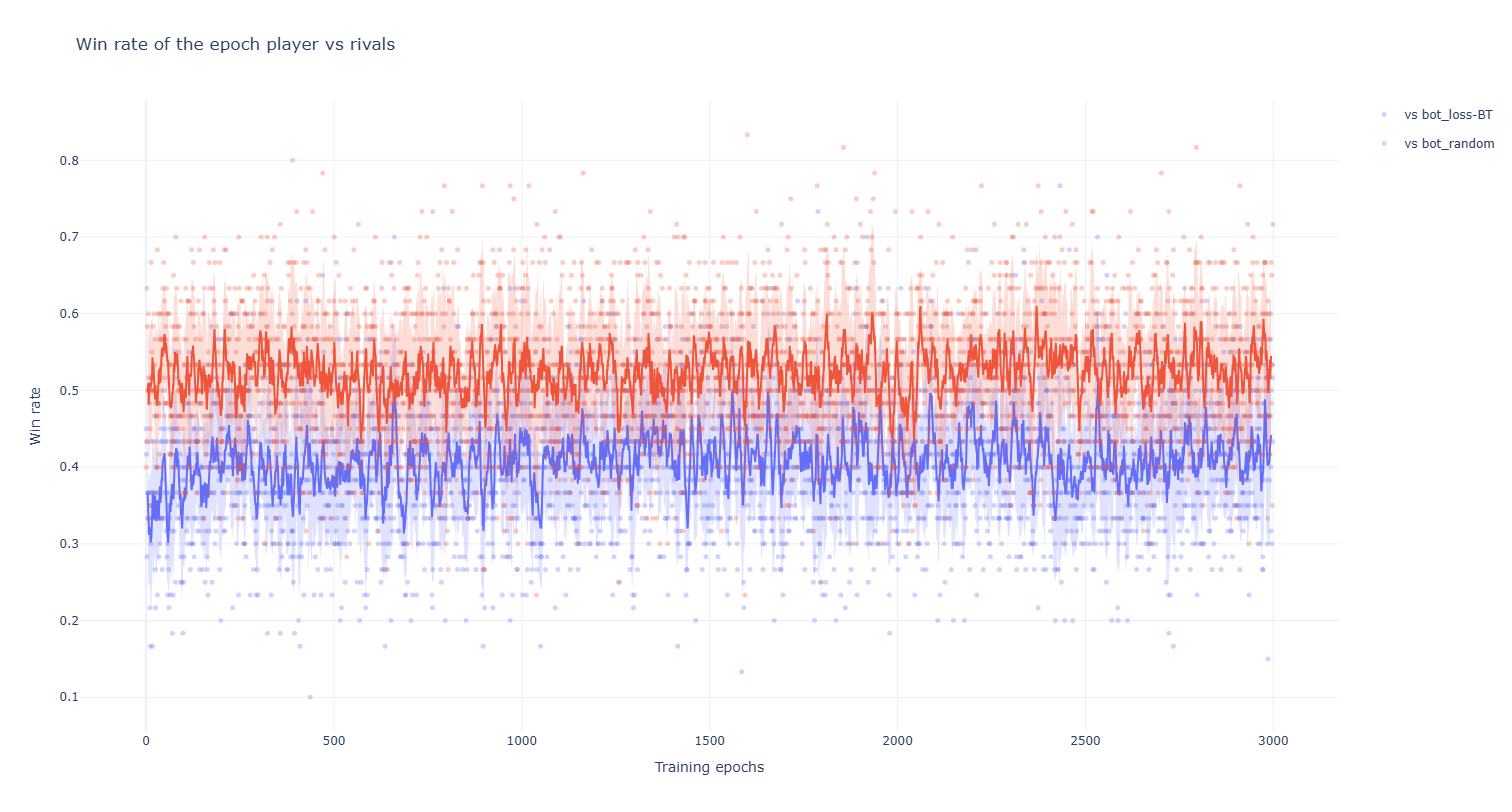

#### Q-values Progress

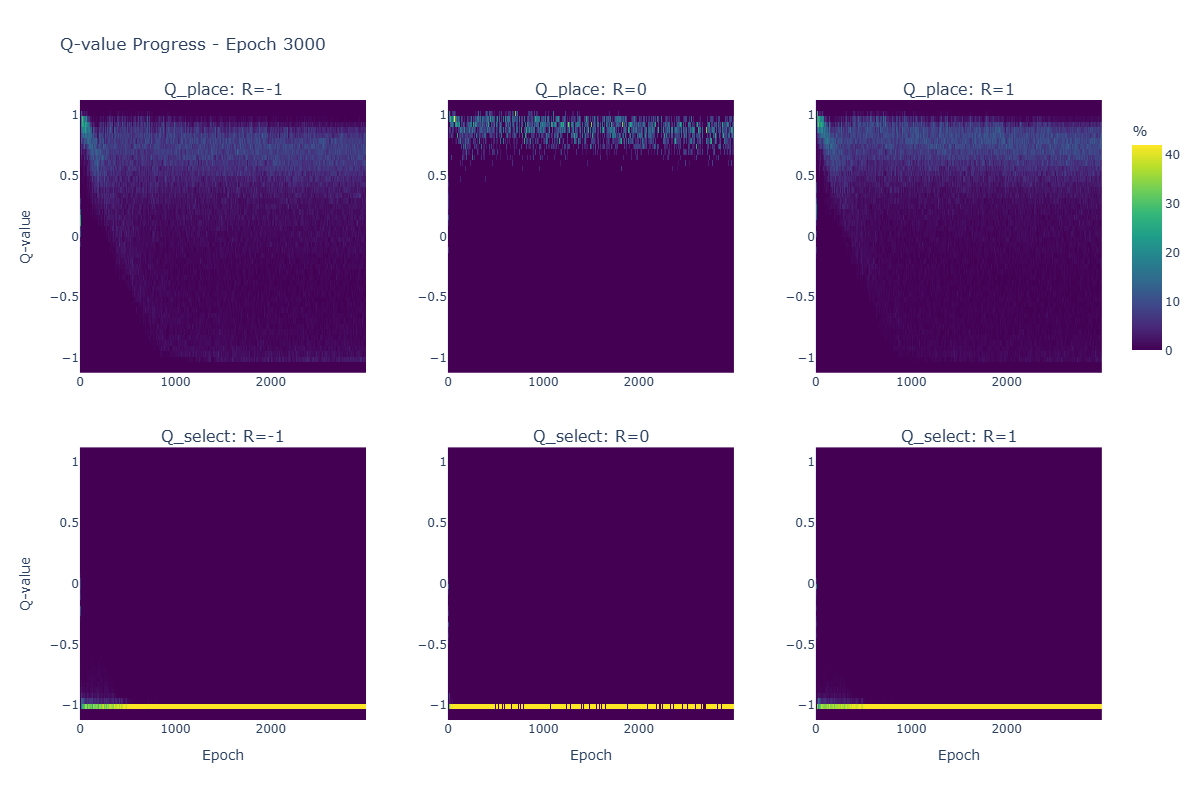

#### Training Loss

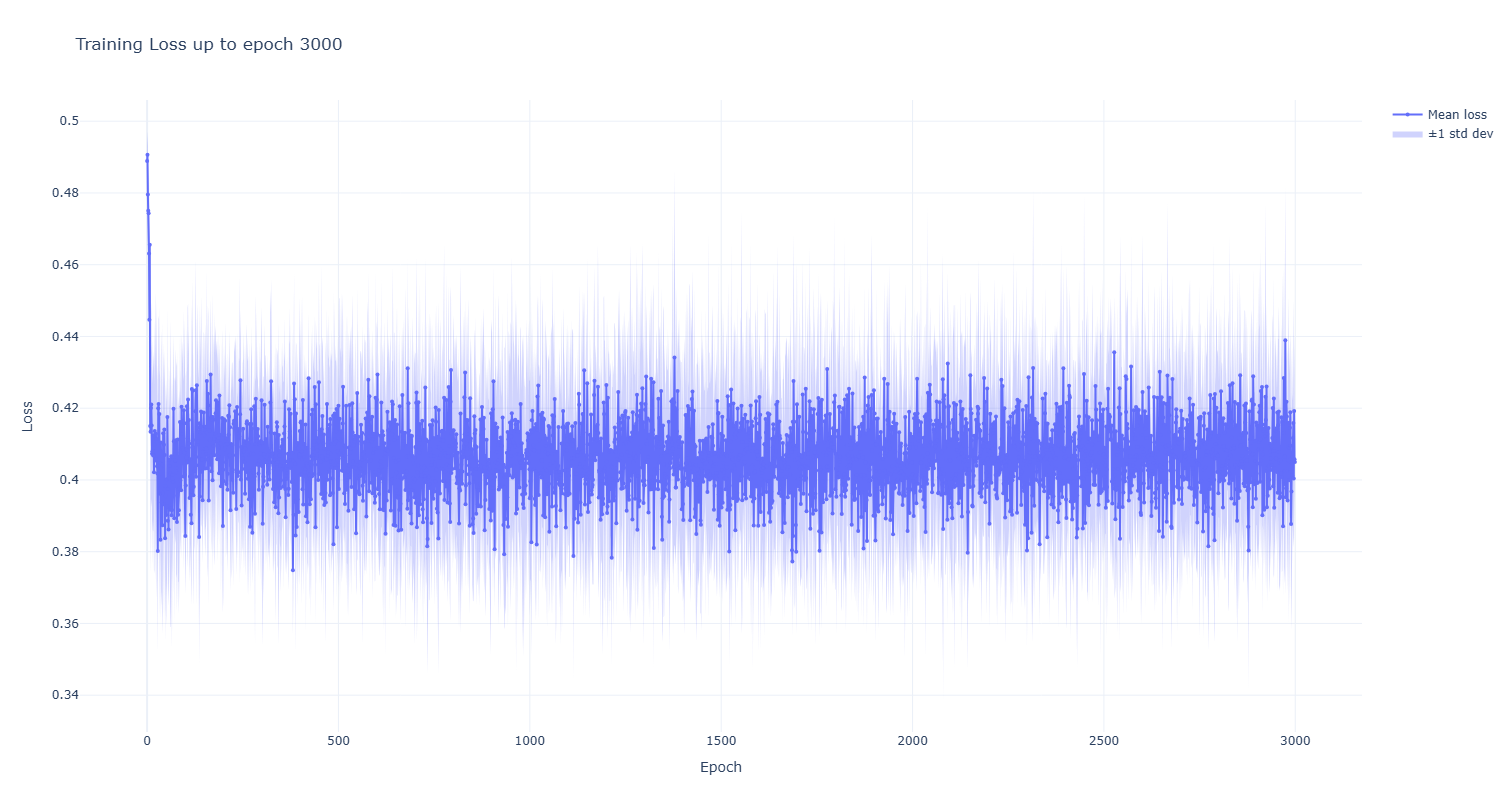

#### Board Comparisons

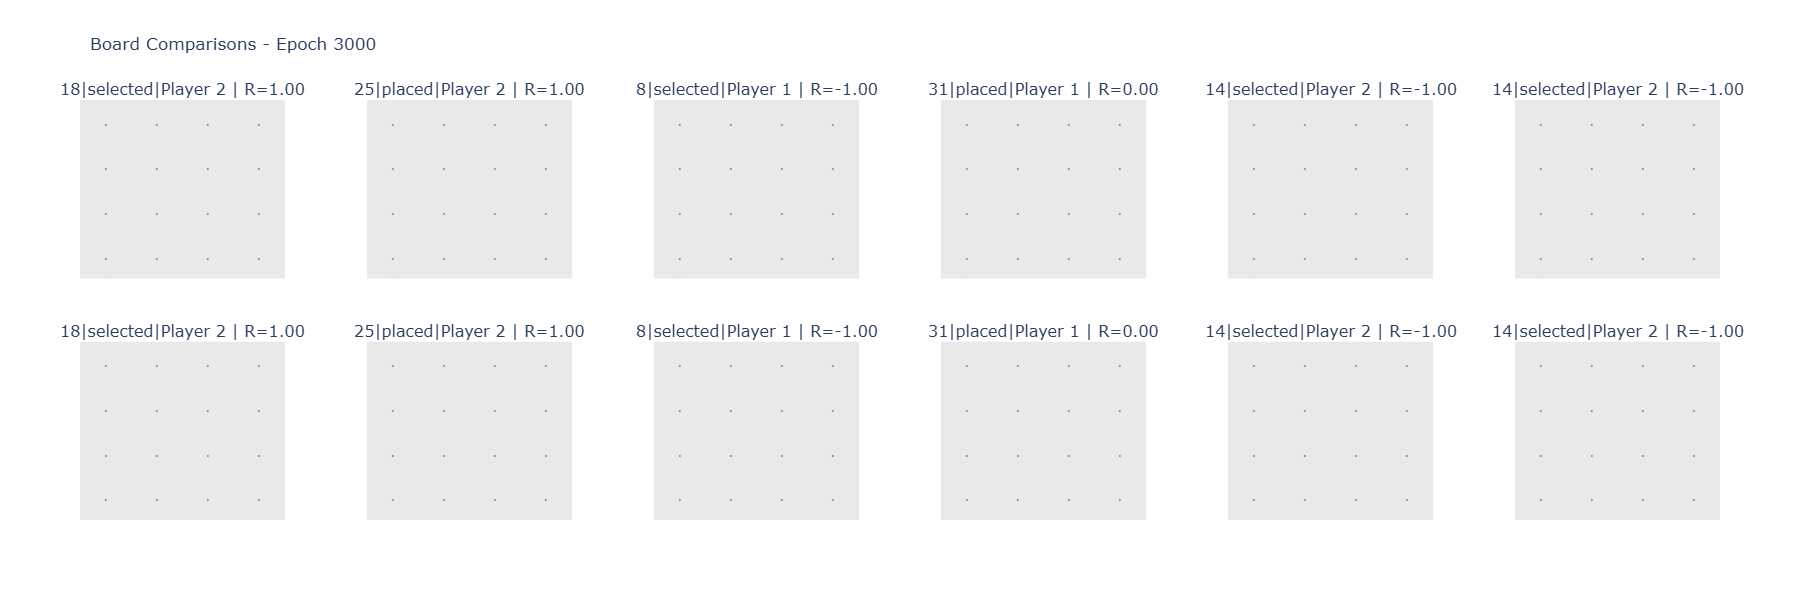

In [9]:
from IPython.display import display, Image, Markdown
from os import path

IMG_FOLDER = r"C:\Users\bravo\Documents\Metodos Numericos Pycharm\Mech Interp\Imagenes de la Bitacoras"

display(Markdown("#### Win Rate"))
display(Image(filename=path.join(IMG_FOLDER, "WinRateParamMod1.png")))

display(Markdown("#### Q-values Progress"))
display(Image(filename=path.join(IMG_FOLDER, "QValueProgressParmMod1.png")))

display(Markdown("#### Training Loss"))
display(Image(filename=path.join(IMG_FOLDER, "TrainingLossParmMod1.png")))

display(Markdown("#### Board Comparisons"))
display(Image(filename=path.join(IMG_FOLDER, "BoardComparisonParamMod1.png")))